In [1]:
#needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_auc_score, plot_confusion_matrix

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

In [2]:
#evaluate function
def evaluate(estimator, X_tr, X_te, y_tr, y_te, roc_auc='skip'):
    '''
    orginial function at : 
    (https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb)
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    
    roc_auc allows you to set how to calculate the roc_auc score: 
    'dec' for decision_function or 'proba' for predict_proba 
    If roc_auc == 'skip', then it ignores calculating the roc_auc_score
    
    Inputs:
        estimator: a fit sklearn-style model or pipeline
        X_tr: array or pandas dataframe
            training input variables
        X_te: array or pandas dataframe
            testing input variables
        y_tr: array or pandas series
            training output variable
        y_te: array or pandas series
            testing output variable
        roc_auc: str
            'skip': default, skips calculating roc_auc
            'dec': use decision_function to calculate roc_auc
            'proba': use predict_proba to calculate roc_auc
            
    '''
    # Grab predictions
    tr_preds = estimator.predict(X_tr)
    te_preds = estimator.predict(X_te)
    
    # output needed for roc_auc_score
    if roc_auc == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec': 
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif roc_auc == 'proba': 
        train_out = estimator.predict_proba(X_train)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec' or 'proba'")    
    
    print("Training Scores:")
    print(f"Train Accuracy: {accuracy_score(y_tr, tr_preds)}")
    print(f"Train Precision: {precision_score(y_tr, tr_preds)}")
    print(f"Train Recall: {recall_score(y_tr, tr_preds)}")
    print(f"Train F1-Score: {f1_score(y_tr, tr_preds)}")
    if type(train_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
        
    print("*" * 10)
    print("Testing Scores:")
    print(f"Test Accuracy: {accuracy_score(y_te, te_preds)}")
    print(f"Test Precision: {precision_score(y_te, te_preds)}")
    print(f"Test Recall: {recall_score(y_te, te_preds)}")
    print(f"Test F1-Score: {f1_score(y_te, te_preds)}")
    if type(test_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")    
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(estimator, X_te, y_te, values_format='.5g', cmap=plt.cm.Oranges)

In [3]:
#pulling our pickled dataframe from EDA notebook
df = pd.read_pickle("../../data/model1.pkl")
df

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total_domestic_minutes,total_domestic_calls,total_domestic_charge,total_charge,churn_rate
0,KS,128,no,yes,25,265.1,110,45.07,197.4,99,...,10.0,3,2.70,1,False,707.2,300,72.86,75.56,med
1,OH,107,no,yes,26,161.6,123,27.47,195.5,103,...,13.7,3,3.70,1,False,611.5,329,55.54,59.24,med-low
2,NJ,137,no,no,0,243.4,114,41.38,121.2,110,...,12.2,5,3.29,0,False,527.2,328,59.00,62.29,high
3,OH,84,yes,no,0,299.4,71,50.90,61.9,88,...,6.6,7,1.78,2,False,558.2,248,65.02,66.80,med-low
4,OK,75,yes,no,0,166.7,113,28.34,148.3,122,...,10.1,3,2.73,3,False,501.9,356,49.36,52.09,med-low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,no,yes,36,156.2,77,26.55,215.5,126,...,9.9,6,2.67,2,False,650.8,286,57.43,60.10,low
3329,WV,68,no,no,0,231.1,57,39.29,153.4,55,...,9.6,4,2.59,3,False,575.8,235,60.94,63.53,low
3330,RI,28,no,no,0,180.8,109,30.74,288.8,58,...,14.1,6,3.81,2,False,661.5,258,63.93,67.74,low
3331,CT,184,yes,no,0,213.8,105,36.35,159.6,84,...,5.0,10,1.35,2,False,512.6,326,56.18,57.53,med


In [4]:
#sanity check the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   international plan      3333 non-null   object 
 3   voice mail plan         3333 non-null   object 
 4   number vmail messages   3333 non-null   int64  
 5   total day minutes       3333 non-null   float64
 6   total day calls         3333 non-null   int64  
 7   total day charge        3333 non-null   float64
 8   total eve minutes       3333 non-null   float64
 9   total eve calls         3333 non-null   int64  
 10  total eve charge        3333 non-null   float64
 11  total night minutes     3333 non-null   float64
 12  total night calls       3333 non-null   int64  
 13  total night charge      3333 non-null   float64
 14  total intl minutes      3333 non-null   

## Model-less evaluation

In [5]:
df["churn"].value_counts(normalize=True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

The model would only be right 14.5% of the time if the model only guessed every customer would leave.

As we devlop our models, we will be optomizing the recall score of our models. As a reult, we may identify more people as leaving, but in reality they stay. The company will spend some resources to retain the customer. However, that the cost of keeping them engaged with the company far outweighs the cost of identifying someone as staying and in actuality they leave the company. The company would lose a customer and then have to spend more resources to get a new customer in their place.

## Pipeline
We will build a pipeline to make preprocessing our data and running model easier than coding everything anew with every model. 

In [6]:
#splits our data set to features and the target "churn"
X = df.drop(["churn"], axis = 1)
y= df["churn"]
#this seed will ensure we use the same random_state in all of our modeling
seed = 42

#holds 10% of my data for final evaluation.
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.25, random_state=seed)

#uses the remaining data and splits the data into test and train data to use while finding best model.
X_train, X_test, y_train, y_test = train_test_split(X_use, y_use, test_size=0.1, random_state=seed)

In [7]:
#what does our training data look like?
X_train.shape

(2249, 23)

In [8]:
# organize columns for the pipeline
num_cols = []
ohe_cols = []

for c in X_train.columns:
    if X_train[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    else:
        ohe_cols.append(c)

In [9]:
print(num_cols)
print(ohe_cols)

['account length', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls', 'total_domestic_minutes', 'total_domestic_calls', 'total_domestic_charge', 'total_charge']
['state', 'international plan', 'voice mail plan', 'churn_rate']


In [10]:
#take all numerical featurres and runs them through a Simple Imputer. 
#Although we are not missing any values, we want to ensure all columns are in the pipeline 
nums = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median'))
    ])

#Takes all categorical variables and OneHotEncodes them
ohe = Pipeline(steps=[
    ("ohe_encoder", OneHotEncoder(handle_unknown="ignore"))
    ])


In [11]:
#builds our preprocessor step using a ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ("num", nums, num_cols),
        ("ohe", ohe, ohe_cols)
    ])

In [12]:
#ensures all of features go through the correct steps during preprocessing
preprocess.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['account length', 'number vmail messages',
                                  'total day minutes', 'total day calls',
                                  'total day charge', 'total eve minutes',
                                  'total eve calls', 'total eve charge',
                                  'total night minutes', 'total night calls',
                                  'total night charge', 'total intl minutes',
                                  'total intl calls', 'total intl charge',
                                  'customer service calls',
                                  'total_domestic_minutes',
                                  'total_domestic_calls',
                                  'total_domestic_charge', 'total_charge']),
                       

## Logistic Regression
The first model will be a logistic regression model, then we will tune some hyperparameters

In [13]:
#features move through the preprocessing pipeline, then we oversample to address the class imbalance,
#then we scale the data using MaxAbsScaler because of our sparse data set, finally we run the model
logreg = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ("scaler", MaxAbsScaler()),
    ('classifier', LogisticRegression(random_state=seed))
])

In [14]:
#fits the data to the pipeline
logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                   'total night calls',
         

In [15]:
cross_validate(logreg, X_train, y_train, return_train_score=True, scoring="recall")

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'fit_time': array([0.33088088, 0.38862777, 0.26476002, 0.30551028, 0.36603332]),
 'score_time': array([0.02952027, 0.02500844, 0.0430479 , 0.02800202, 0.03401351]),
 'test_score': array([0.625     , 0.6875    , 0.67692308, 0.70769231, 0.71875   ]),
 'train_score': array([0.74031008, 0.75581395, 0.74708171, 0.74319066, 0.75581395])}

The model stopped at the total number of iterations and could not complete its analysis. This will be adjusted when we tune the hyperparameters.

Training Scores:
Train Accuracy: 0.791907514450867
Train Precision: 0.38522012578616355
Train Recall: 0.7608695652173914
Train F1-Score: 0.511482254697286
ROC-AUC: 0.8381434792278412
**********
Testing Scores:
Test Accuracy: 0.768
Test Precision: 0.3333333333333333
Test Recall: 0.6111111111111112
Test F1-Score: 0.43137254901960786
ROC-AUC: 0.77466251298027


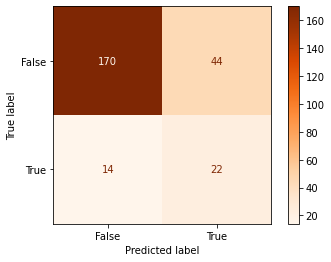

In [16]:
evaluate(logreg, X_train, X_test, y_train, y_test, roc_auc='proba')

The evaluation function shows the does not perform very well. While precision metric is not the most important, its still must be accounted for in deciding what model to use. The recall score dropped quite a bit meaning the model is failing to caputure churned customers.

## Logistical Regression with Tuning

In [17]:
logreg_tuned = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ("scaler", MaxAbsScaler()),
    ('classifier', LogisticRegression(random_state=seed))
])

In [18]:
#here we will adjust the max iterations, penalty, the regulation power 
#and use a liblinear solver due to the choices in penalty and the size of the data set
param_grid = {
    'classifier__max_iter': [1000, 10000, 100000],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [1, 5, 10, 100],
    'classifier__solver': ["liblinear"]
}

In [19]:
grid = GridSearchCV(logreg_tuned, param_grid)

In [20]:
output = grid.fit(X_train, y_train)

In [21]:
#best parameters based on the grid search
output.best_params_

{'classifier__C': 1,
 'classifier__max_iter': 1000,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

Training Scores:
Train Accuracy: 0.7927967985771454
Train Precision: 0.3864353312302839
Train Recall: 0.7608695652173914
Train F1-Score: 0.5125523012552301
ROC-AUC: 0.8378485529271839
**********
Testing Scores:
Test Accuracy: 0.768
Test Precision: 0.3333333333333333
Test Recall: 0.6111111111111112
Test F1-Score: 0.43137254901960786
ROC-AUC: 0.7728452751817239


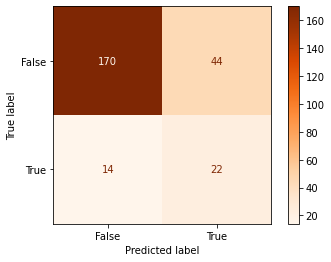

In [22]:
evaluate(output.best_estimator_, X_train, X_test, y_train, y_test, roc_auc='proba')

The tuned model performed the same as the untuned model. This may be caused by the number of features we use for model. There may some multicollinearity issues causing poor performance. Considering time constraints we will move on to the next model. 

## Nearest Neighbors

In [23]:
#We will use the same steps as before, except we will use a KNeighbors model.
knn = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ("scaler", MaxAbsScaler()),
    ('classifier', KNeighborsClassifier())
])

In [24]:
knn.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                   'total night calls',
         

In [25]:
cross_validate(knn, X_train, y_train, return_train_score=True, scoring="recall")

{'fit_time': array([0.04700494, 0.03701138, 0.03900385, 0.04100633, 0.03200316]),
 'score_time': array([0.65804887, 0.12500024, 0.17201161, 0.1420095 , 0.12700772]),
 'test_score': array([0.375     , 0.546875  , 0.53846154, 0.44615385, 0.46875   ]),
 'train_score': array([0.88372093, 0.89534884, 0.88326848, 0.89883268, 0.89534884])}

Training Scores:
Train Accuracy: 0.9141840818141396
Train Precision: 0.6387096774193548
Train Recall: 0.922360248447205
Train F1-Score: 0.7547649301143584
ROC-AUC: 0.9746862983364868
**********
Testing Scores:
Test Accuracy: 0.82
Test Precision: 0.37142857142857144
Test Recall: 0.3611111111111111
Test F1-Score: 0.3661971830985915
ROC-AUC: 0.6572559709241953


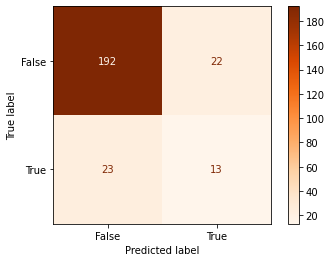

In [26]:
evaluate(knn, X_train, X_test, y_train, y_test, roc_auc='proba')

This model is wildly overfit to the testing data. All of our scores dropped when applied to the testing data.

## Nearest Neighbors with Tuning

In [27]:
knn_tuned = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ("scaler", MaxAbsScaler()),
    ('classifier', KNeighborsClassifier())
])

In [28]:
#for this model, we will adjust the number of nearst neighbors we will use smaller numbers becaue the data was so overfitted,
#the weights of those neighbors, the power parameter and use the euclidean metric
param_grid = {
    'classifier__n_neighbors': [2, 4, 5],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [2, 3, 5],
    'classifier__metric': ["euclidean"]
}

In [29]:
grid = GridSearchCV(knn_tuned, param_grid)

In [30]:
output = grid.fit(X_train, y_train)

In [31]:
output.best_params_

{'classifier__metric': 'euclidean',
 'classifier__n_neighbors': 2,
 'classifier__p': 2,
 'classifier__weights': 'uniform'}

Training Scores:
Train Accuracy: 0.989773232547799
Train Precision: 1.0
Train Recall: 0.9285714285714286
Train F1-Score: 0.962962962962963
ROC-AUC: 0.9973496923419083
**********
Testing Scores:
Test Accuracy: 0.836
Test Precision: 0.3684210526315789
Test Recall: 0.19444444444444445
Test F1-Score: 0.2545454545454545
ROC-AUC: 0.6532969885773624


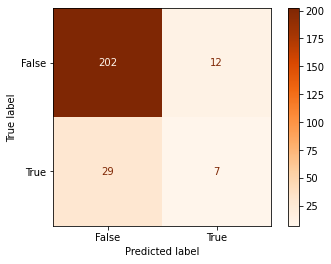

In [32]:
evaluate(output.best_estimator_, X_train, X_test, y_train, y_test, roc_auc='proba')

Even with a smaller number neighbors, this model is drastically overfitting. This is most likely due to the large number of features taken into account for this model.

## Decision Tree

In [33]:
#we will follow the same steps as before, but without the scaling step.
#Decision trees do not need scaling because they are nonparametric
dt = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', DecisionTreeClassifier(random_state=seed))
])

In [34]:
dt.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                   'total night calls',
         

In [35]:
cross_validate(dt, X_train, y_train, return_train_score=True, scoring="recall")

{'fit_time': array([0.08800578, 0.09600711, 0.11434841, 0.10100365, 0.10200691]),
 'score_time': array([0.01100111, 0.00899935, 0.00900626, 0.00800252, 0.01199961]),
 'test_score': array([0.78125   , 0.890625  , 0.81538462, 0.86153846, 0.859375  ]),
 'train_score': array([1., 1., 1., 1., 1.])}

Training Scores:
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1-Score: 1.0
ROC-AUC: 1.0
**********
Testing Scores:
Test Accuracy: 0.948
Test Precision: 0.8484848484848485
Test Recall: 0.7777777777777778
Test F1-Score: 0.8115942028985507
ROC-AUC: 0.8772066458982347


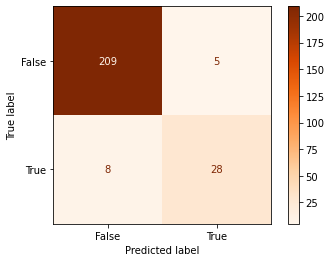

In [36]:
evaluate(dt, X_train, X_test, y_train, y_test, roc_auc='proba')

Like the other untuned models, this model is very overfit. With so many parameters and no max depth set the model goes down as far as it can resulting in the overfitting.

## Decision Tree with Tuning

In [37]:
dt_tuned = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', DecisionTreeClassifier(random_state=seed))
])

In [38]:
#For this tuned model, we decided to adjust for the max depth to prevent over fitting
#additionally we wanted to adjust the number of samples needed to split internal nodes 
#by trying to constrain the model a bit more.
#and, we adjusted the min_samples_leaaf parameter to prevent the tree from splitting nodes to far down. 
param_grid = {
    "classifier__max_depth": [3, 5, 7, 10],
    "classifier__min_samples_split": [2, 3, 5,10],
    "classifier__min_samples_leaf": [2, 3, 5,10]
}

In [39]:
grid_dt = GridSearchCV(dt_tuned, param_grid)

In [40]:
output = grid_dt.fit(X_train, y_train)

In [41]:
output.best_params_

{'classifier__max_depth': 5,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 2}

Training Scores:
Train Accuracy: 0.9764339706536238
Train Precision: 0.996309963099631
Train Recall: 0.8385093167701864
Train F1-Score: 0.9106239460370995
ROC-AUC: 0.9392814434950217
**********
Testing Scores:
Test Accuracy: 0.968
Test Precision: 0.9666666666666667
Test Recall: 0.8055555555555556
Test F1-Score: 0.8787878787878789
ROC-AUC: 0.9069963655244029


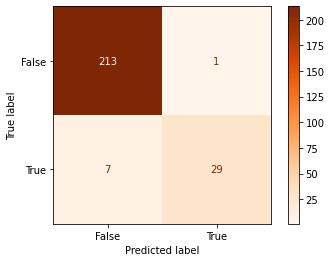

In [42]:
evaluate(output.best_estimator_, X_train, X_test, y_train, y_test, roc_auc='proba')

This model is the best performing model yet. Accurancy is maintained, and there is only a slight drop in the recall score. These score shows the model is fitting the testing data well and able to generalize to the testing data.

## XGBoost
Due to the nature of our business problem, we are focused more on analysis rather than building a black box model, however that does not mean at least one of these options should be investigated to see the results.

In [43]:
xgb = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', XGBClassifier(random_state=seed))
])

In [44]:
xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                   'total night calls',
         

In [45]:
cross_validate(xgb, X_train, y_train, return_train_score=True, scoring = "recall")

{'fit_time': array([0.31402278, 0.35802722, 0.34702539, 0.31502318, 0.35802698]),
 'score_time': array([0.01900291, 0.02200532, 0.01900172, 0.01900125, 0.02000189]),
 'test_score': array([0.8125    , 0.875     , 0.84615385, 0.87692308, 0.875     ]),
 'train_score': array([1., 1., 1., 1., 1.])}

Training Scores:
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1-Score: 1.0
ROC-AUC: 1.0
**********
Testing Scores:
Test Accuracy: 0.976
Test Precision: 1.0
Test Recall: 0.8333333333333334
Test F1-Score: 0.9090909090909091
ROC-AUC: 0.9273104880581514


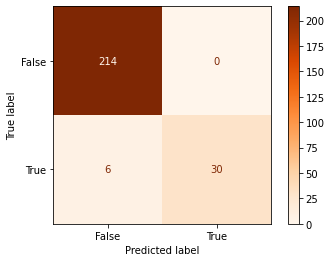

In [46]:
evaluate(xgb, X_train, X_test, y_train, y_test, roc_auc='proba')

As with the the other orginal models, this is overfitting to the testing data. While this Model may not be suited for our business solution, we will still tune some hyper parameters to see if we can improve performance.

## XGBoost with Tuning

In [47]:
xgb_grid = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', XGBClassifier(random_state=seed))
])

In [48]:
#for tuning this model, we decided to investigate the number of trees in each round.
#we chose slighlty smaller numbers out of compuational complexity concerns.
#We wanted look at how the weighting of the trees effects the models performance
#and same as with the simple decision tree, we decided to control for the max depth, to limit overfitting. 
param_grid = {
    "classifier__n_estimators": [100, 500, 1000],
    "classifier__learning_rate": [.0001, .001, .01, .1],
    "classifier__max_depth": [2, 3, 4, 5]
}

In [49]:
grid = GridSearchCV(xgb_grid, param_grid)

In [50]:
output = grid.fit(X_train, y_train)

In [51]:
output.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 500}

Training Scores:
Train Accuracy: 0.9968875055580257
Train Precision: 1.0
Train Recall: 0.9782608695652174
Train F1-Score: 0.989010989010989
ROC-AUC: 1.0
**********
Testing Scores:
Test Accuracy: 0.976
Test Precision: 1.0
Test Recall: 0.8333333333333334
Test F1-Score: 0.9090909090909091
ROC-AUC: 0.9248442367601246


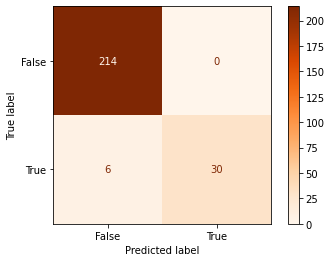

In [52]:
evaluate(output.best_estimator_, X_train, X_test, y_train, y_test, roc_auc='proba')

The model did perform well on the testing data. The accuracy and precision are almost perfect, too perfect actually, shows signs of overfitting. And based on drop in recall performance from the training to testing data shows the same.

## Final Model

After running Logistic Regression, KNearest Neighbors, Decsion Tree and XGBoost models and after tuning the hyperparameters to improve performance, we have determined the best performing model is the tuned Decsion Tree. We will use this model to test on our hold out set. To prevent data leakage, the hold out set has not been touched by any of our previous modeling. 

In [53]:
#here we pull up data split for the final model to work on.
X = df.drop(["churn"],axis = 1)
y= df["churn"]
seed = 42

#holds 10% of my data for final evaluation.
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.1, random_state=seed)

#uses the remaining data and splits the data into test and train data to use while finding best model.
X_train, X_test, y_train, y_test = train_test_split(X_use, y_use, test_size=0.2, random_state=seed)

In [54]:
dt_final = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', DecisionTreeClassifier(max_depth = 5,
                                          min_samples_split=2,
                                          min_samples_leaf=2,
                                          random_state=seed))
])
dt_final.fit(X_use, y_use)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                   'total night calls',
         

Training Scores:
Train Accuracy: 0.976325441813938
Train Precision: 0.9890710382513661
Train Recall: 0.8438228438228438
Train F1-Score: 0.910691823899371
ROC-AUC: 0.9381341616260694
**********
Testing Scores:
Test Accuracy: 0.9730538922155688
Test Precision: 1.0
Test Recall: 0.8333333333333334
Test F1-Score: 0.9090909090909091
ROC-AUC: 0.9487840825350038


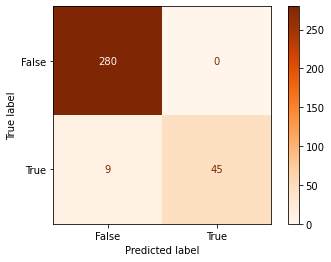

In [55]:
evaluate(dt_final, X_use, X_hold, y_use, y_hold, roc_auc='proba')

Text(0, 0.5, 'True')

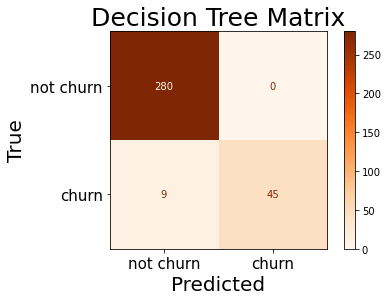

In [75]:
plot_confusion_matrix(dt_final, X_hold, y_hold, display_labels=["not churn", "churn"], cmap=plt.cm.Oranges, values_format='.5g')
plt.title("Decision Tree Matrix", fontsize = 25)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.xlabel(xlabel = "Predicted", fontsize= 20)
plt.ylabel(ylabel = "True", fontsize= 20)

We are very pleased with performance of the tuned Decision Tree on the hold out dataset. The precision and recall scores are high on the training and testing data. There is a 1 % percent drop in recall performance but this is a small reduction. Our model is very picky about who it idemtifies and it is very good at classifying the curn status of a customer.

## Feature Importance
Here we will go into our model and pull out what features carried the most weight in making decisions when splitting the nodes.

In [ ]:
#size of our holdout training data
dt_final["preprocess"].fit_transform(X_use).shape

In [ ]:
pd.DataFrame(dt_final["preprocess"].fit_transform(X_train)).head()

In [ ]:
#raw feature importances
dt_final['classifier'].feature_importances_

In [ ]:
#list numerical features in our model
num_cols_final = dt_final['preprocess'].transformers_[0][2]
num_cols_final

In [ ]:
#list of categorical features in our model
ohe_cols_transformed = dt_final['preprocess'].transformers_[1][1]['ohe_encoder'].get_feature_names(ohe_cols)
ohe_cols_transformed

In [ ]:
#complete list of features in our model
final_cols =[*num_cols_final, *ohe_cols_transformed]
final_cols

In [ ]:
#joing the features and weights and organizing them in descending order.
features = pd.DataFrame.from_dict(dict(zip(final_cols, dt_final['classifier'].feature_importances_)), 
                       orient='index').sort_values(by=0, ascending=False).head(10).reset_index()
features

In [ ]:
#This code is found at :
#https://scikit-learn.org/stable/auto_examples/tree/
#plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py
n_nodes = dt_final["classifier"].tree_.node_count
children_left = dt_final["classifier"].tree_.children_left
children_right = dt_final["classifier"].tree_.children_right
feature = dt_final["classifier"].tree_.feature
threshold = dt_final["classifier"].tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

In [ ]:
#visualizes the tree
fig, ax = plt.subplots(figsize=(15,15))
plot_tree(dt_final["classifier"], feature_names=final_cols, fontsize=10)
plt.show()